# Exercise 11: Generalized linear models

## Table of Contents

* Traditional GLM using `statsmodels`
* tutorial on GLMs using neural data (adapted from Pillow SfN workshop 2016)

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.io import loadmat

import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

# For retina displays only 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

## Traditional GLM using `statsmodels`

In [2]:
# Creating some fake data
n = 20

X1 = np.random.normal(loc=.5, scale=2, size=n)
X2 = np.random.normal(loc=2, scale=2, size=n)
X3 = np.random.normal(loc=0, scale=2, size=n)

## Neural spiking GLM from Pillow's SfN workshop


This is a tutorial illustrating the fitting of a linear-Gaussian GLM
(also known as linear least-squares regression model) and a Poisson GLM
(aka  "linear-nonlinear-Poisson" model) to retinal ganglion cell spike
trains stimulated with binary temporal white noise. 

(Data from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details). 

*Last updated: Nov 9, 2016 (JW Pillow)*

--------------------------
Loaded RGC data: cell 2
Number of stim frames: 144051  (20.0 minutes)
Time bin size: 8.3 ms
Number of spikes: 49954 (mean rate=20.8 Hz)



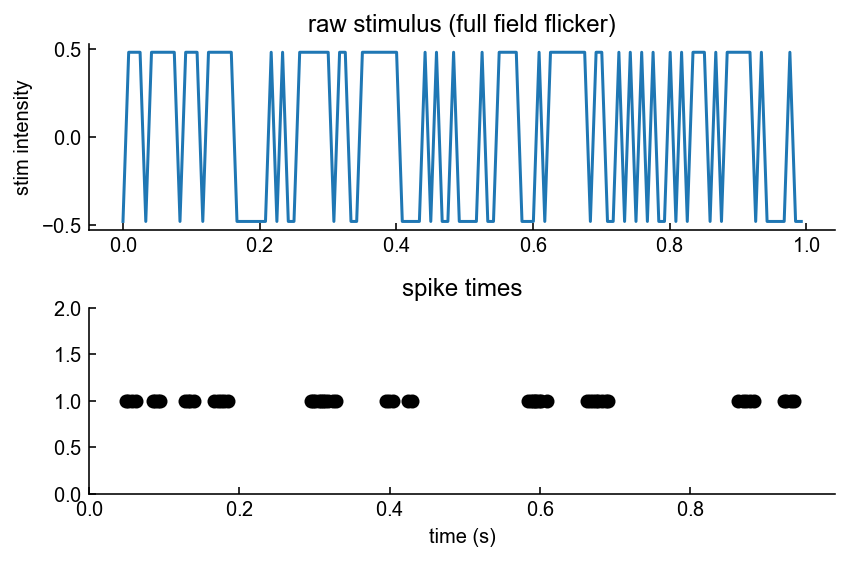

In [3]:
### ====  1. Load the raw data ============

datdir = os.path.join('data', 'data_RGCs') # directory where stimulus lives  

Stim = loadmat(os.path.join(datdir, 'Stim.mat'))['Stim']                     # stimulus (temporal binary white noise)
Stim = Stim.T[0]
stimtimes = loadmat(os.path.join(datdir, 'stimtimes.mat'))['stimtimes']             # stim frame times in seconds (if desired)
stimtimes = stimtimes.T[0]
SpTimes = loadmat(os.path.join(datdir, 'SpTimes.mat'))['SpTimes'][0]               # load spike times (in units of stimulus frames)
for i, data in enumerate(SpTimes):
    SpTimes[i] = data.T[0]


### Pick a cell to work with
cellnum = 2                             # (0-1 are OFF cells; 2-3 are ON cells).
tsp = SpTimes[cellnum]

### Compute some basic statistics on the data
dtStim = stimtimes[1]-stimtimes[0] # time bin size for stimulus (s)
RefreshRate = 1/dtStim             # Refresh rate of the monitor
nT = len(Stim)                     # number of time bins in stimulus
nsp = len(tsp)                     # number of spikes

### Print out some basic info
print('--------------------------')
print('Loaded RGC data: cell {}'.format(cellnum))
print('Number of stim frames: {:d}  ({:.1f} minutes)'.format(nT, nT*dtStim/60))
print('Time bin size: {:.1f} ms'.format(dtStim*1000))
print('Number of spikes: {} (mean rate={:.1f} Hz)\n'.format(nsp, nsp/nT*60))

### Let's visualize some of the raw data
plt.subplot(211)
iiplot = np.arange(120) # bins of stimulus to plot
ttplot = iiplot*dtStim  # time bins of stimulus
plt.plot(ttplot,Stim[iiplot])
plt.title('raw stimulus (full field flicker)')
plt.ylabel('stim intensity')

plt.subplot(212)
tspplot = tsp[(tsp>=ttplot[0])&(tsp<ttplot[-1])]
plt.plot(tspplot, [1]*len(tspplot), 'ko')
plt.xlim([ttplot[0], ttplot[-1]]); plt.ylim([0,2])
plt.title('spike times')
plt.xlabel('time (s)')
plt.show()

(0.0, 0.9925319949999999)

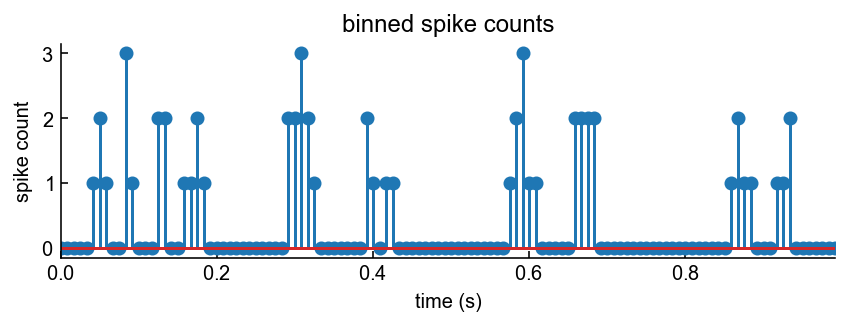

In [4]:
### ==== 2. Bin the spike train ===== 

# For now we will assume we want to use the same time bin size as the time
# bins used for the stimulus. Later, though, we'll wish to vary this.

tbins = np.arange(nT+1)*dtStim     # time bin centers for spike train binnning
sps,_ = np.histogram(tsp,tbins)     # binned spike train

### Replot the responses we'll putting into our regression as counts
plt.subplot(212)
plt.cla()
plt.stem(ttplot,sps[iiplot])
plt.title('binned spike counts')
plt.ylabel('spike count')
plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])

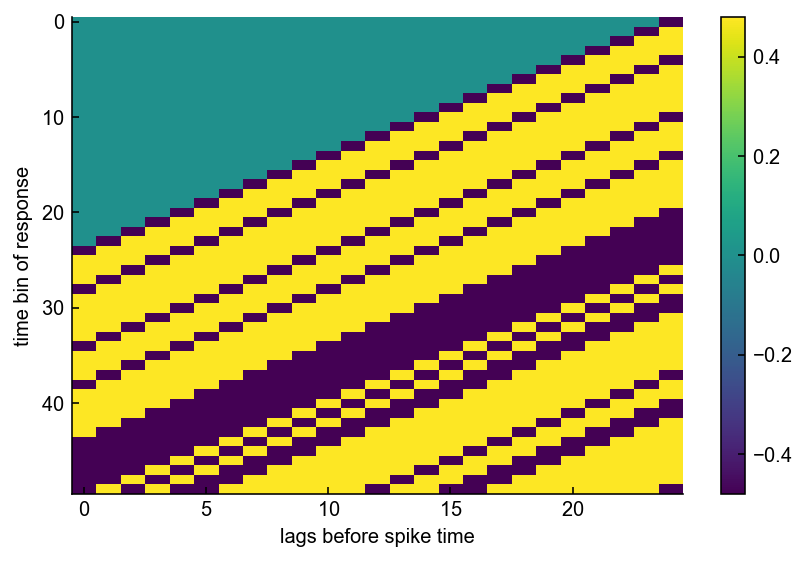

In [5]:
### ==== 3. Build the design matrix: slow version ======
# This is a necessary step before we can fit the model: assemble a matrix
# that contains the relevant regressors for each time bin of the response,
# known as a design matrix.  Each row of this matrix contains the relevant
# stimulus chunk for predicting the spike count at a given time bin

### Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 25     # Try varying this, to see how performance changes!

# Build the design matrix: Slow version
paddedStim = np.hstack((np.zeros((ntfilt-1)), Stim))  # pad early bins of stimulus with zero
Xdsgn = np.zeros((nT,ntfilt))
for j in np.arange(nT):
    Xdsgn[j] = paddedStim[j:j+ntfilt]                 # grab last 'nkt' bins of stmiulus and insert into this row

    
# Let's visualize a small part of the design matrix just to see it
plt.clf() 
plt.imshow(Xdsgn[:50], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

# Notice it has a structure where every row is a shifted copy of the row
# above, which comes from the fact that for each time bin of response,
# we're grabbing the preceding 'nkt' bins of stimulus as predictor

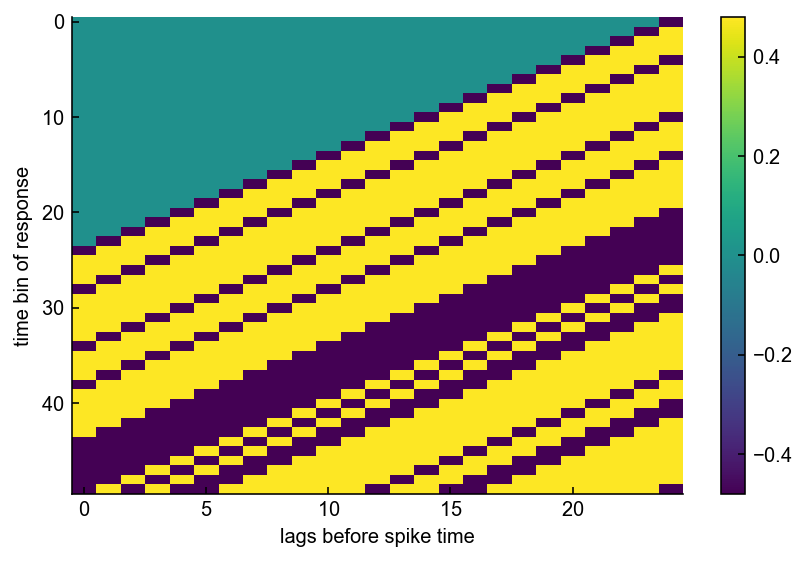

In [6]:
### ==== 3b. Build the design matrix: fast version =======

# Of course there's a faster / more elegant way to do this. The design
# matrix here is known as a 'Hankel' matrix, which is the same as a
# Toeplitz matrix flipped left to right.

### With no for loop
from scipy.linalg import hankel

paddedStim = np.hstack((np.zeros(ntfilt-1), Stim))   # pad early bins of stimulus with zero
Xdsgn = hankel(paddedStim[:-ntfilt+1], Stim[-ntfilt:])

# (You can check for you like that this gives the same matrix as the one created above!)

plt.clf() 
plt.imshow(Xdsgn[:50], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

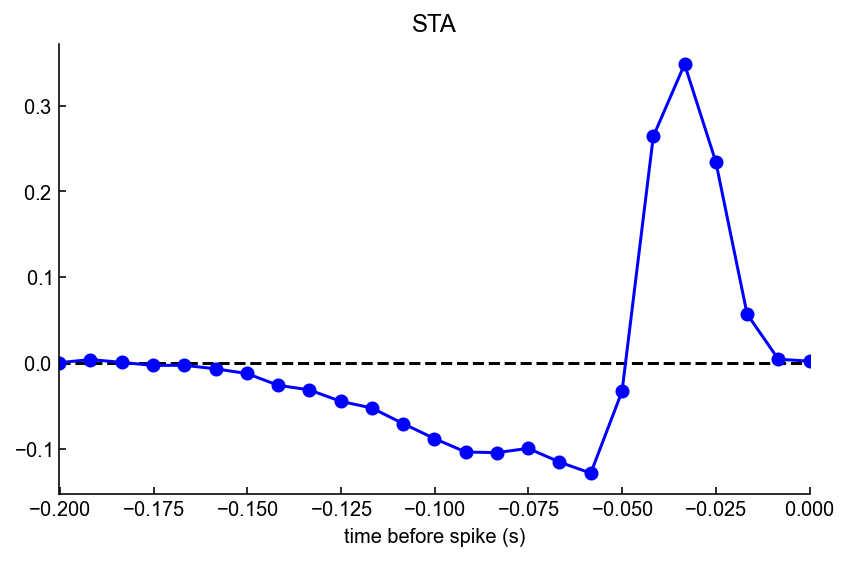

In [7]:
### === 4. Compute and visualize the spike-triggered average (STA) ====

# When the stimulus is Gaussian white noise, the STA provides an unbiased
# estimator for the filter in a GLM / LNP model (as long as the nonlinearity
# results in an STA whose expectation is not zero; feel free 
# to ignore this parenthetical remark if you're not interested in technical
# details. It just means that if the nonlinearity is symmetric, 
# eg. x^2, then this condition won't hold, and the STA won't be useful).

# In many cases it's useful to visualize the STA (even if your stimuli are
# not white noise), just because if we don't see any kind of structure then
# this may indicate that we have a problem (e.g., a mismatch between the
# design matrix and binned spike counts.

### It's extremely easy to compute the STA now that we have the design matrix
sta = (Xdsgn.T @ sps)/nsp

### Plot it
ttk = np.arange(-ntfilt+1,1)*dtStim  # time bins for STA (in seconds)
plt.clf()
plt.plot(ttk,ttk*0, 'k--')
plt.plot(ttk, sta, 'bo-')
plt.title('STA')
plt.xlabel('time before spike (s)')
plt.xlim([ttk[0],ttk[-1]])
plt.show()

# If you're still using cell #1, this should look like a biphasic filter
# with a negative lobe just prior to the spike time.

# (By contrast, if this looks like garbage then it's a good chance we did something wrong!)

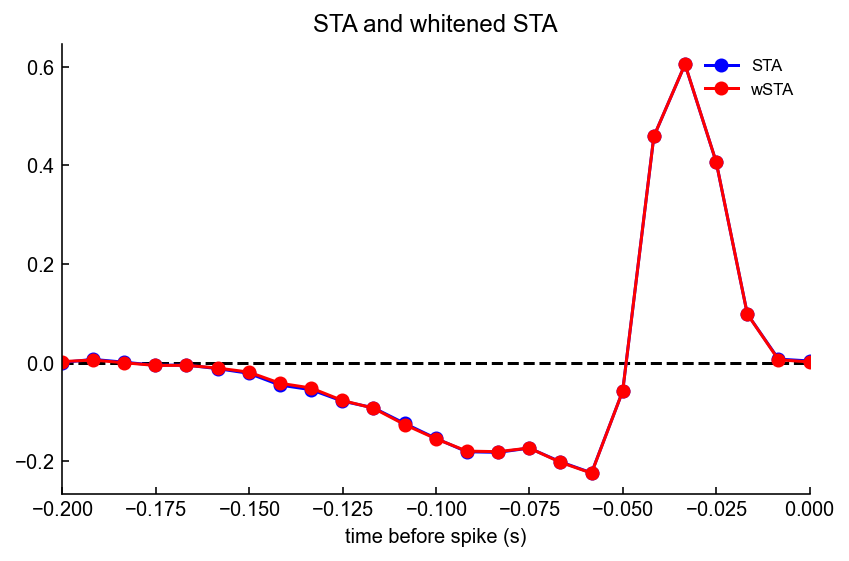

In [8]:
### ===== 4b. whitened STA (ML fit to filter for linear-Gaussian GLM) ======

# If the stimuli are non-white, then the STA is generally a biased
# estimator for the linear filter. In this case we may wish to compute the
# "whitened" STA, which is also the maximum-likelihood estimator for the filter of a 
# GLM with "identity" nonlinearity and Gaussian noise (also known as
# least-squares regression).

# If the stimuli have correlations this ML estimate may look like garbage
# (more on this later when we come to "regularization").  But for this
# dataset the stimuli are white, so we don't (in general) expect a big
# difference from the STA.  (This is because the whitening matrix
# (Xdsng.T * Xdsgn)^{-1} is close to a scaled version of the identity.)

from numpy.linalg import inv, norm
### whitened STA
wsta = inv(Xdsgn.T @ Xdsgn) @ sta * nsp
# this is just the least-squares regression formula!

### Let's plot them both (rescaled as unit vectors so we can see differences in their shape).
plt.clf()
plt.plot(ttk,ttk*0, 'k--')
plt.plot(ttk, sta/norm(sta), 'bo-', label="STA")
plt.plot(ttk, wsta/norm(wsta), 'ro-', label="wSTA")
plt.legend()
plt.title('STA and whitened STA')
plt.xlabel('time before spike (s)')
plt.xlim([ttk[0],ttk[-1]])
plt.show()

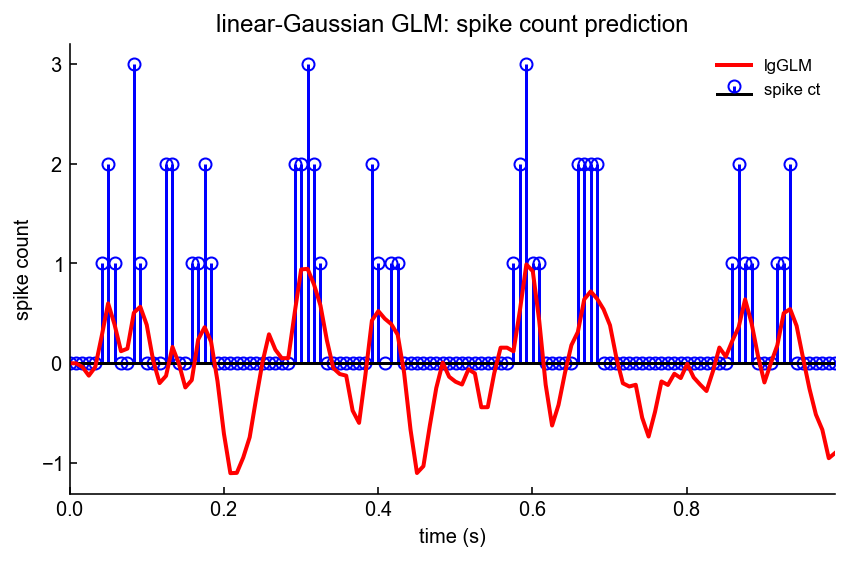

In [9]:
### ===== 4c. Predicting spikes with a linear-Gaussian GLM ======

# The whitened STA can actually be used to predict spikes because it
# corresponds to a proper estimate of the model parameters (i.e., for a
# Gaussian GLM). Let's inspect this prediction

sppred_lgGLM = Xdsgn @ wsta  # predicted spikes from linear-Gaussian GLM

# Let's see how good this "prediction" is
# (Prediction in quotes because we are (for now) looking at the performance
# on training data, not test data... so it isn't really aprediction!)

### Plot real spike train and prediction
plt.clf()
markerline,_,_ = plt.stem(ttplot,sps[iiplot], linefmt='b-', basefmt='k-', label="spike ct")
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'blue')
plt.plot(ttplot,sppred_lgGLM[iiplot], color='red', linewidth=2, label="lgGLM")
plt.title('linear-Gaussian GLM: spike count prediction')
plt.ylabel('spike count'); plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])
plt.legend()
plt.show()

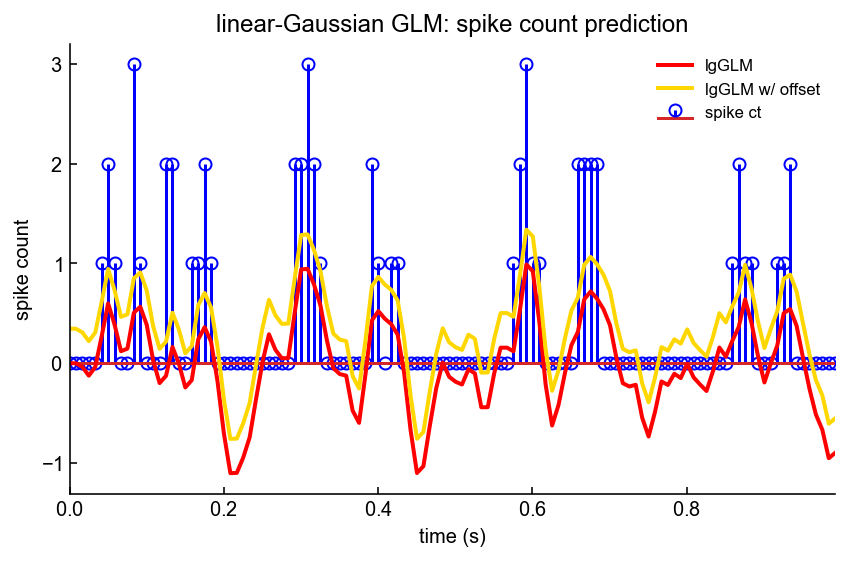

Training perf (R^2): lin-gauss GLM, no offset: 0.12
Training perf (R^2): lin-gauss GLM, w/ offset: 0.39


In [10]:
### ===== 4d. Fitting and predicting with a linear-Gaussian-GLM with offset =====

# Oops, one thing we forgot above was to include an offset or "constant"
# term in the design matrix, which will allow our prediction to have
# non-zero mean (since the stimulus here was normalized to have zero mean).

### Updated design matrix
Xdsgn2 = np.hstack((np.ones((nT,1)), Xdsgn))     # just add a column of ones

### Compute whitened STA
MLwts = inv(Xdsgn2.T @ Xdsgn2) @ (Xdsgn2.T @ sps)  # this is just the LS regression formula
const = MLwts[0]   # the additive constant
wsta2 = MLwts[1:]  # the linear filter part

### Now redo prediction (with offset)
sppred_lgGLM2 = const + Xdsgn @ wsta2

### Plot this stuff
plt.clf()
markerline,_,_ = plt.stem(ttplot,sps[iiplot], linefmt='b-', label="spike ct")
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'blue')
plt.plot(ttplot,sppred_lgGLM[iiplot], color="red", linewidth=2, label = 'lgGLM')
plt.plot(ttplot,sppred_lgGLM2[iiplot], color="gold", linewidth=2, label = 'lgGLM w/ offset') 
plt.title('linear-Gaussian GLM: spike count prediction')
plt.ylabel('spike count'); plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])
plt.legend()
plt.show()

### Let's report the relevant training error (squared prediction error on
### training data) so far just to see how we're doing:
mse1 = np.mean((sps-sppred_lgGLM)**2)   # mean squared error, GLM no offset
mse2 = np.mean((sps-sppred_lgGLM2)**2)  # mean squared error, with offset
rss = np.mean((sps-np.mean(sps))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, no offset: {:.2f}'.format(1-mse1/rss))
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))

In [11]:
### ======  5. Poisson GLM ====================

# Let's finally move on to the LNP / Poisson GLM!

# Package available for download from
# https://github.com/pavanramkumar/pyglmnet
from pyglmnet import GLM

### This is super-easy if we rely on built-in GLM fitting code
reg_lambda = np.logspace(np.log(1e-6), np.log(1e-8), 100, base=np.exp(1))
glm_poissonexp = GLM(distr='poisson', verbose=False, alpha=0.05,
            max_iter=1000, learning_rate=2e-1, score_metric='pseudo_R2',
            reg_lambda=reg_lambda, eta=4.0)

glm_poissonexp.fit(Xdsgn, sps)

pGLMconst = glm_poissonexp[-1].fit_['beta0']
pGLMfilt = glm_poissonexp[-1].fit_['beta']

# The 'GLM' function can fit a GLM for us. Here we have specified that
# we want the noise model to be Poisson. The default setting for the link
# function (the inverse of the nonlinearity) is 'log', so default
# nonlinearity is 'exp').  

### Compute predicted spike rate on training data
ratepred_pGLM = np.exp(pGLMconst + Xdsgn @ pGLMfilt)
# equivalent to if we had just written np.exp(Xdsgn2 @ pGLMwts)/dtStim

ValueError: operands could not be broadcast together with shapes (100,) (25,) 